Following the EDA carried out in `a-EDA-ALLMOTH-ALLSITE`, we proceed with an analysis of only the stable-stations. We consider the following,
1. De-seasonalising and de-scaling the monthly moth rate
1. ? Changepoint analysis with the daily weather
1. ? Changepoint analysis with the monthly weather

In [1]:
# Don infill months from previous years
# Narrative 

setwd("/data/notebooks/jupyterlab-workshop/")
source("R/AnalysisFunctions.R")

library(ggplot2)
library(reticulate)

input_stations <- c("T02-2", "T03-1", "T04-2", "T05-1", "T06-2", "T08-1", "T09-2")
date_min <- "1900-02-02"
date_max <- "2022-01-01"

tbl_daily <- get_daily_moth_rate(input_stations, date_min, date_max)
tbl_monthly <- get_monthly_moth_rate(input_stations, date_min, date_max)
print(tbl_monthly, n=2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

`summarise()` regrouping output by 'SITECODE', 'DATE' (override with `.groups` argument)

`summarise()` regrouping output by 'SITECODE', 'DATE' (override with `.groups` argument)

`summarise()` regrouping output by 'SITECODE', 'station', 'year', 'monthname' (override with `.groups` argument)



# A tibble: 1,484 x 5
  SITECODE station  value date       value_type       
  <fct>    <chr>    <dbl> <date>     <chr>            
1 T02      T02-2    0.567 1996-06-30 monthly_abun_rate
2 T02      T02-2   13.3   1996-07-31 monthly_abun_rate
# … with 1,482 more rows


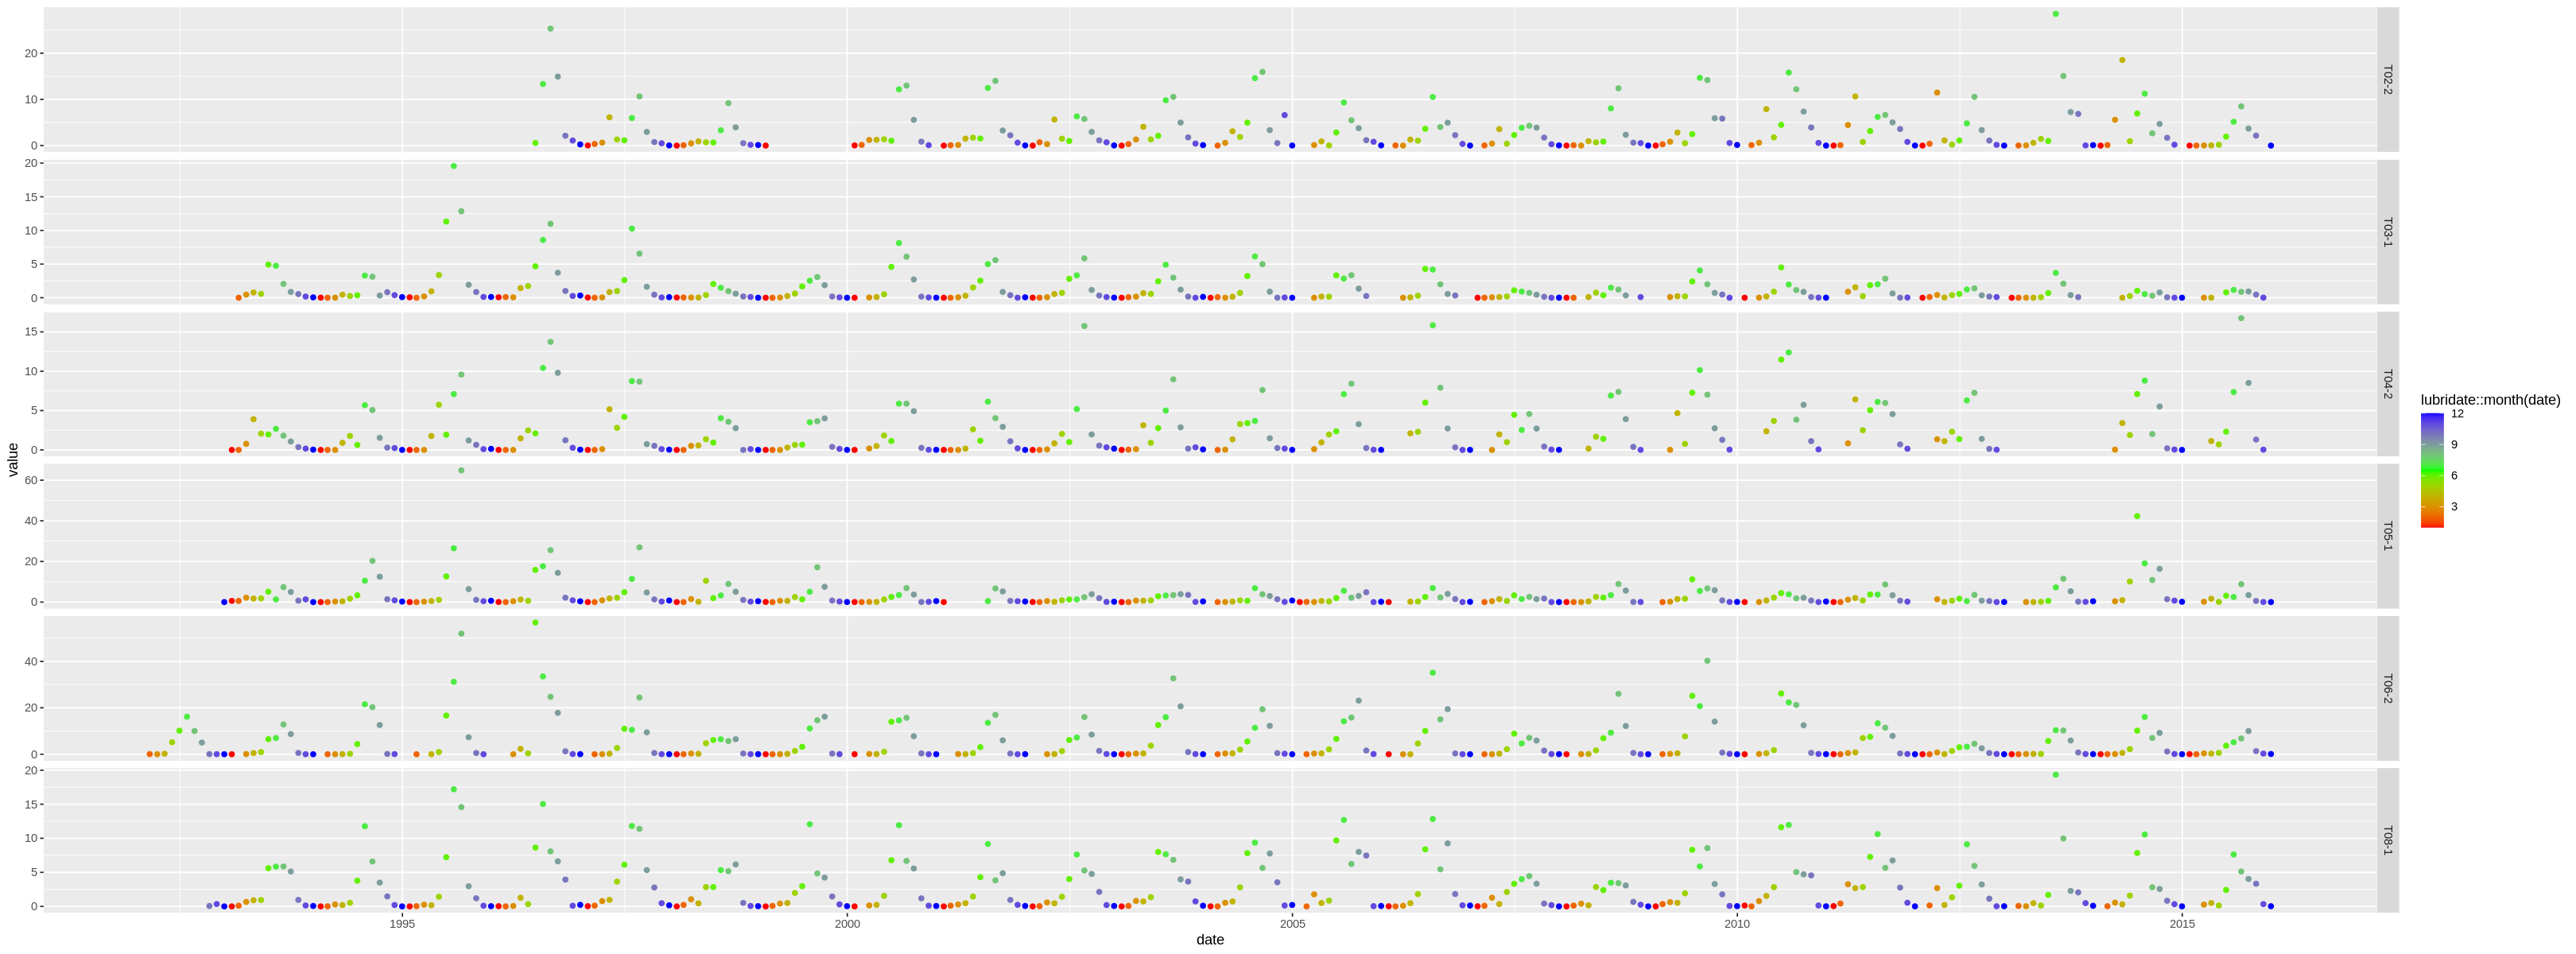

In [2]:
options(repr.plot.width = 27, repr.plot.height = 10)
tbl_monthly %>%
ggplot(aes(x=date, y=value, colour=lubridate::month(date))) +
geom_point() +
scale_color_gradientn(colours = rainbow(3)) +
facet_grid(
    rows=vars(station),
    scales="free_y"
)

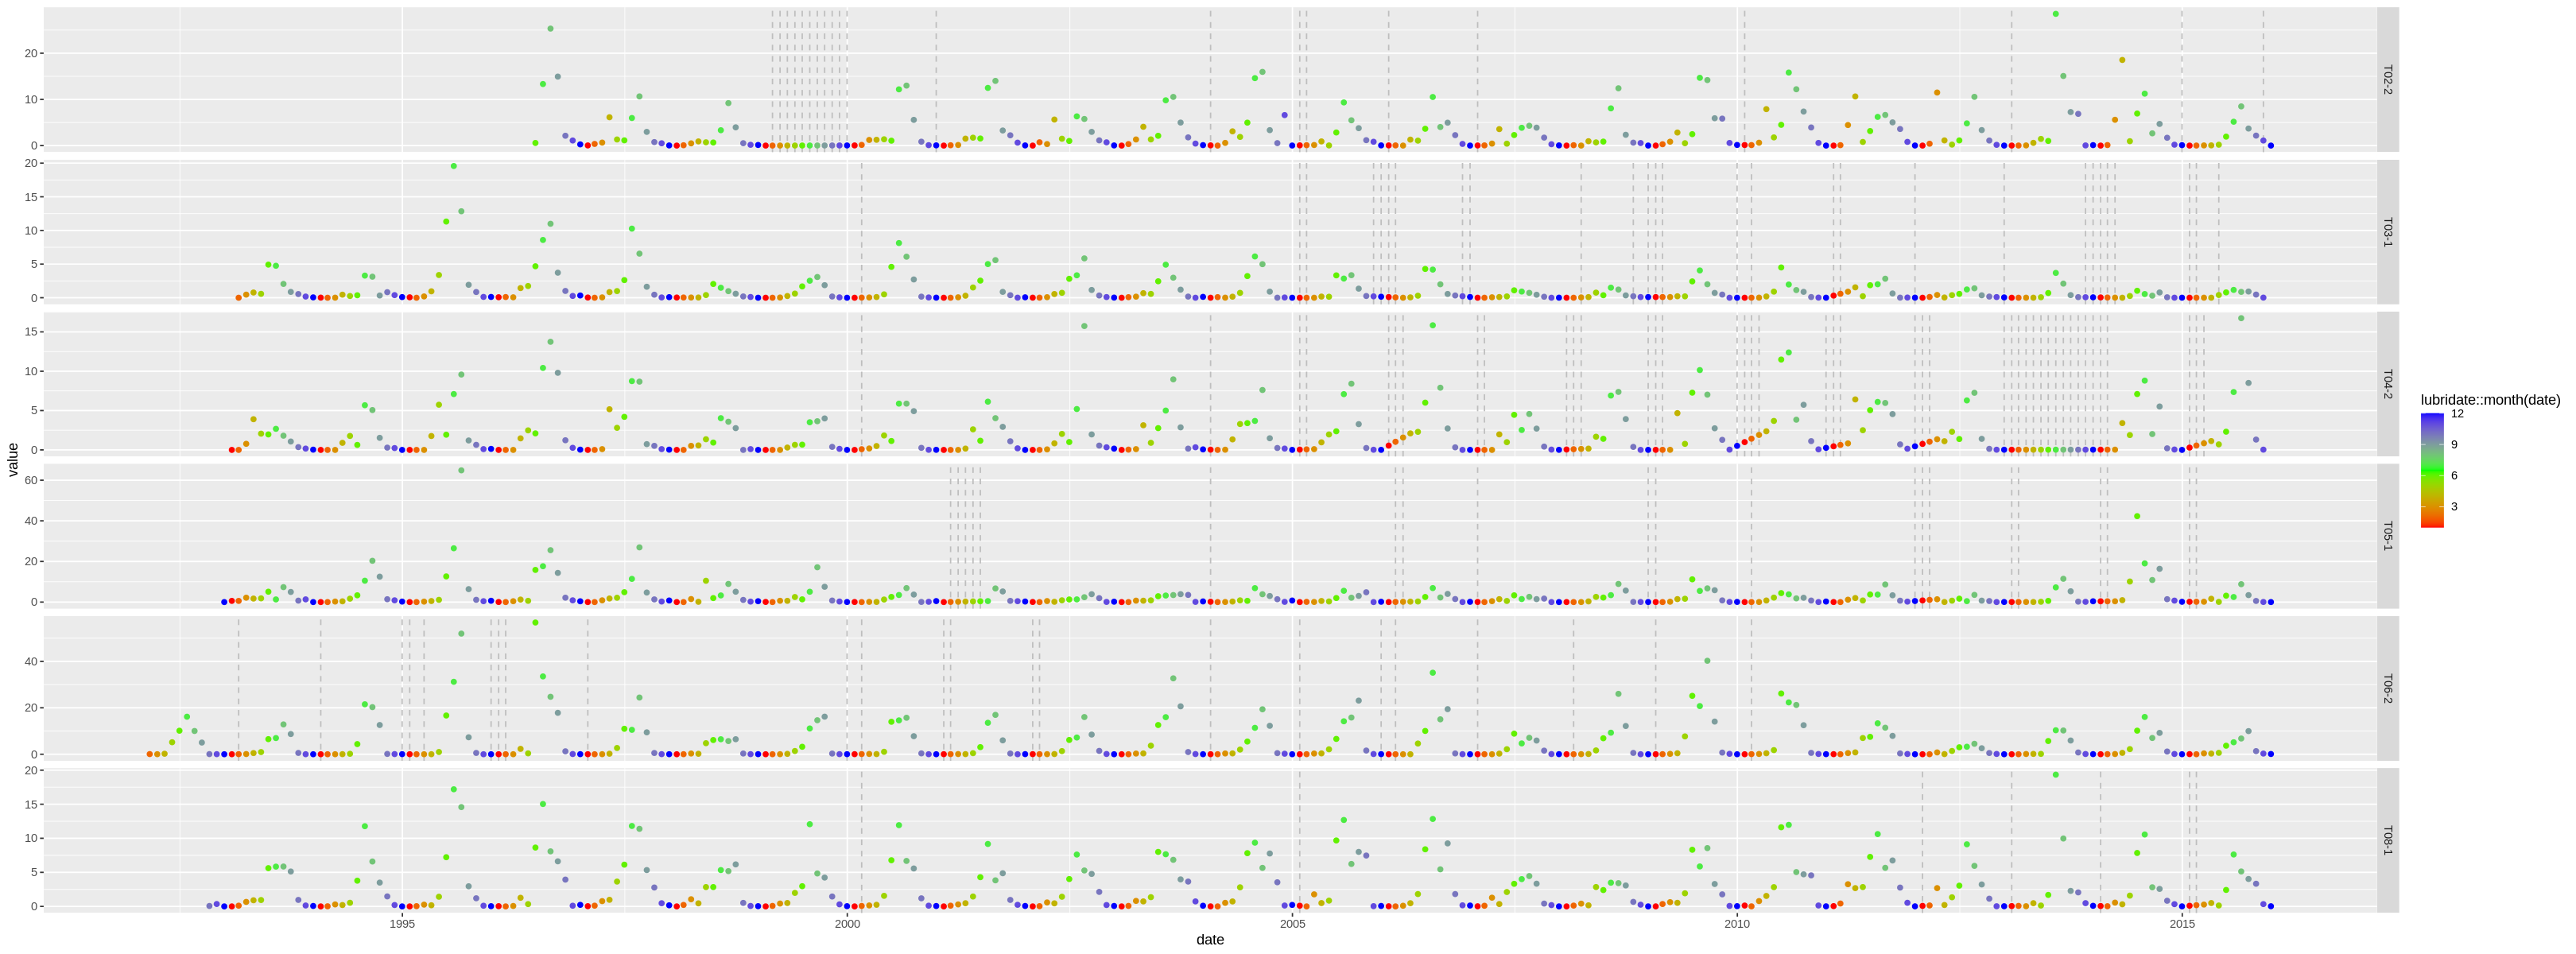

In [3]:
tbl_interp <- interpolate_monthly(tbl_monthly)
tbl_interp %>%
ggplot(aes(x=date, y=value, colour=lubridate::month(date))) +
geom_vline(data=tbl_interp %>% filter(missing), aes(xintercept=date), linetype=2, colour='grey') +
geom_point() +
scale_color_gradientn(colours = rainbow(3)) +
facet_grid(
    rows=vars(station),
    scales="free_y"
)

In [4]:
print(tbl_interp, n=2)

# A tibble: 1,627 x 8
  station SITECODE value_type        date        value     m      c missing
  <chr>   <fct>    <chr>             <date>      <dbl> <dbl>  <dbl> <lgl>  
1 T02-2   T02      monthly_abun_rate 1996-06-30  0.567 0.411 -3981. FALSE  
2 T02-2   T02      monthly_abun_rate 1996-07-31 13.3   0.411 -3981. FALSE  
# … with 1,625 more rows


`summarise()` regrouping output by 'station' (override with `.groups` argument)



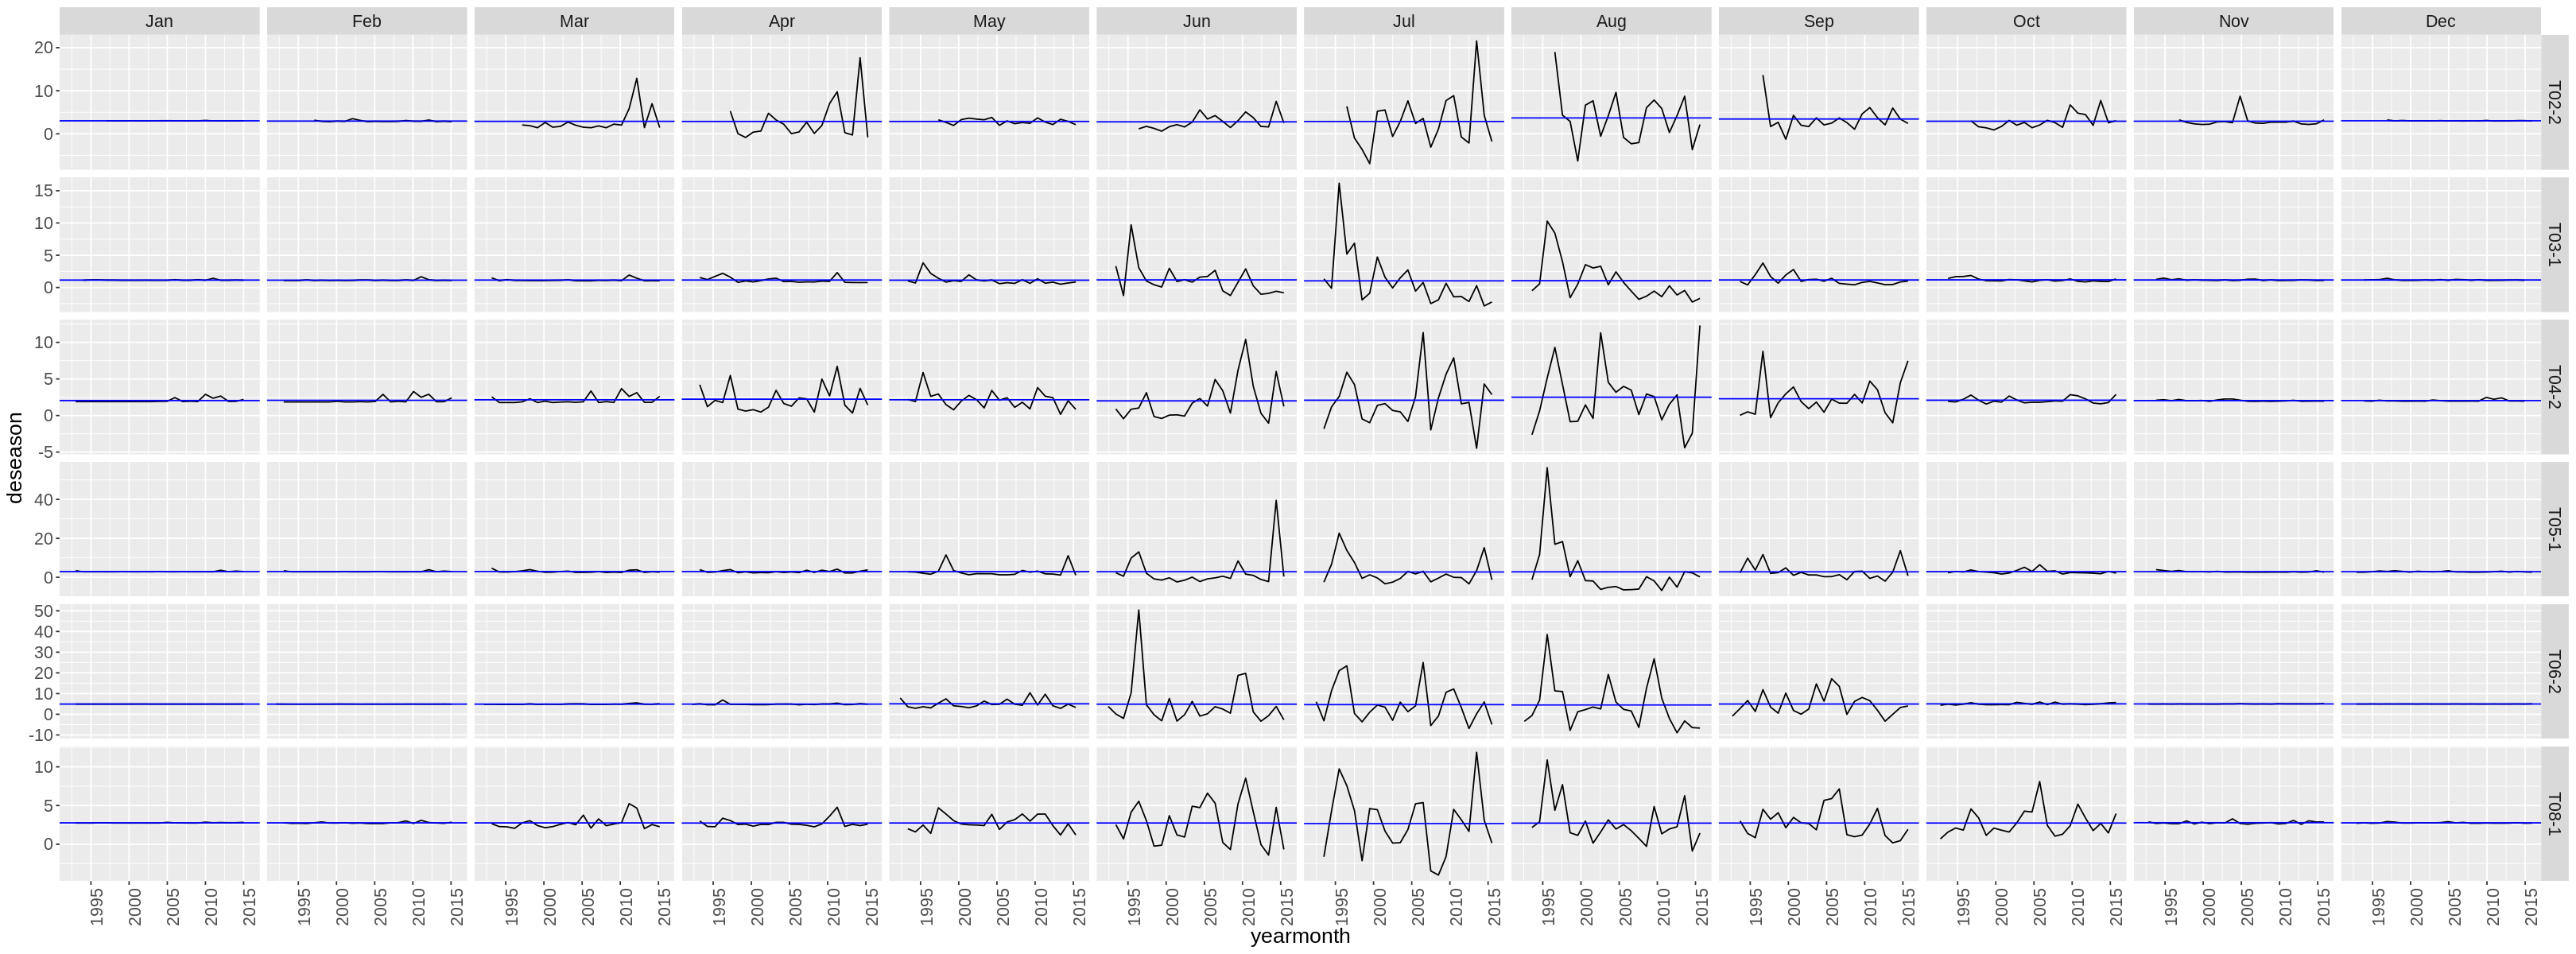

In [5]:
# standardising the variance doesn't seem very effective...?

tbl_deseason <- deseason(tbl_interp)

tbl_deseason %>% mutate(yearmonth=tsibble::yearmonth(date)) %>%
tsibble::as_tsibble(index=yearmonth, key=station) %>% 
    feasts::gg_subseries(y=deseason) + 
    theme(text = element_text(size = 16))

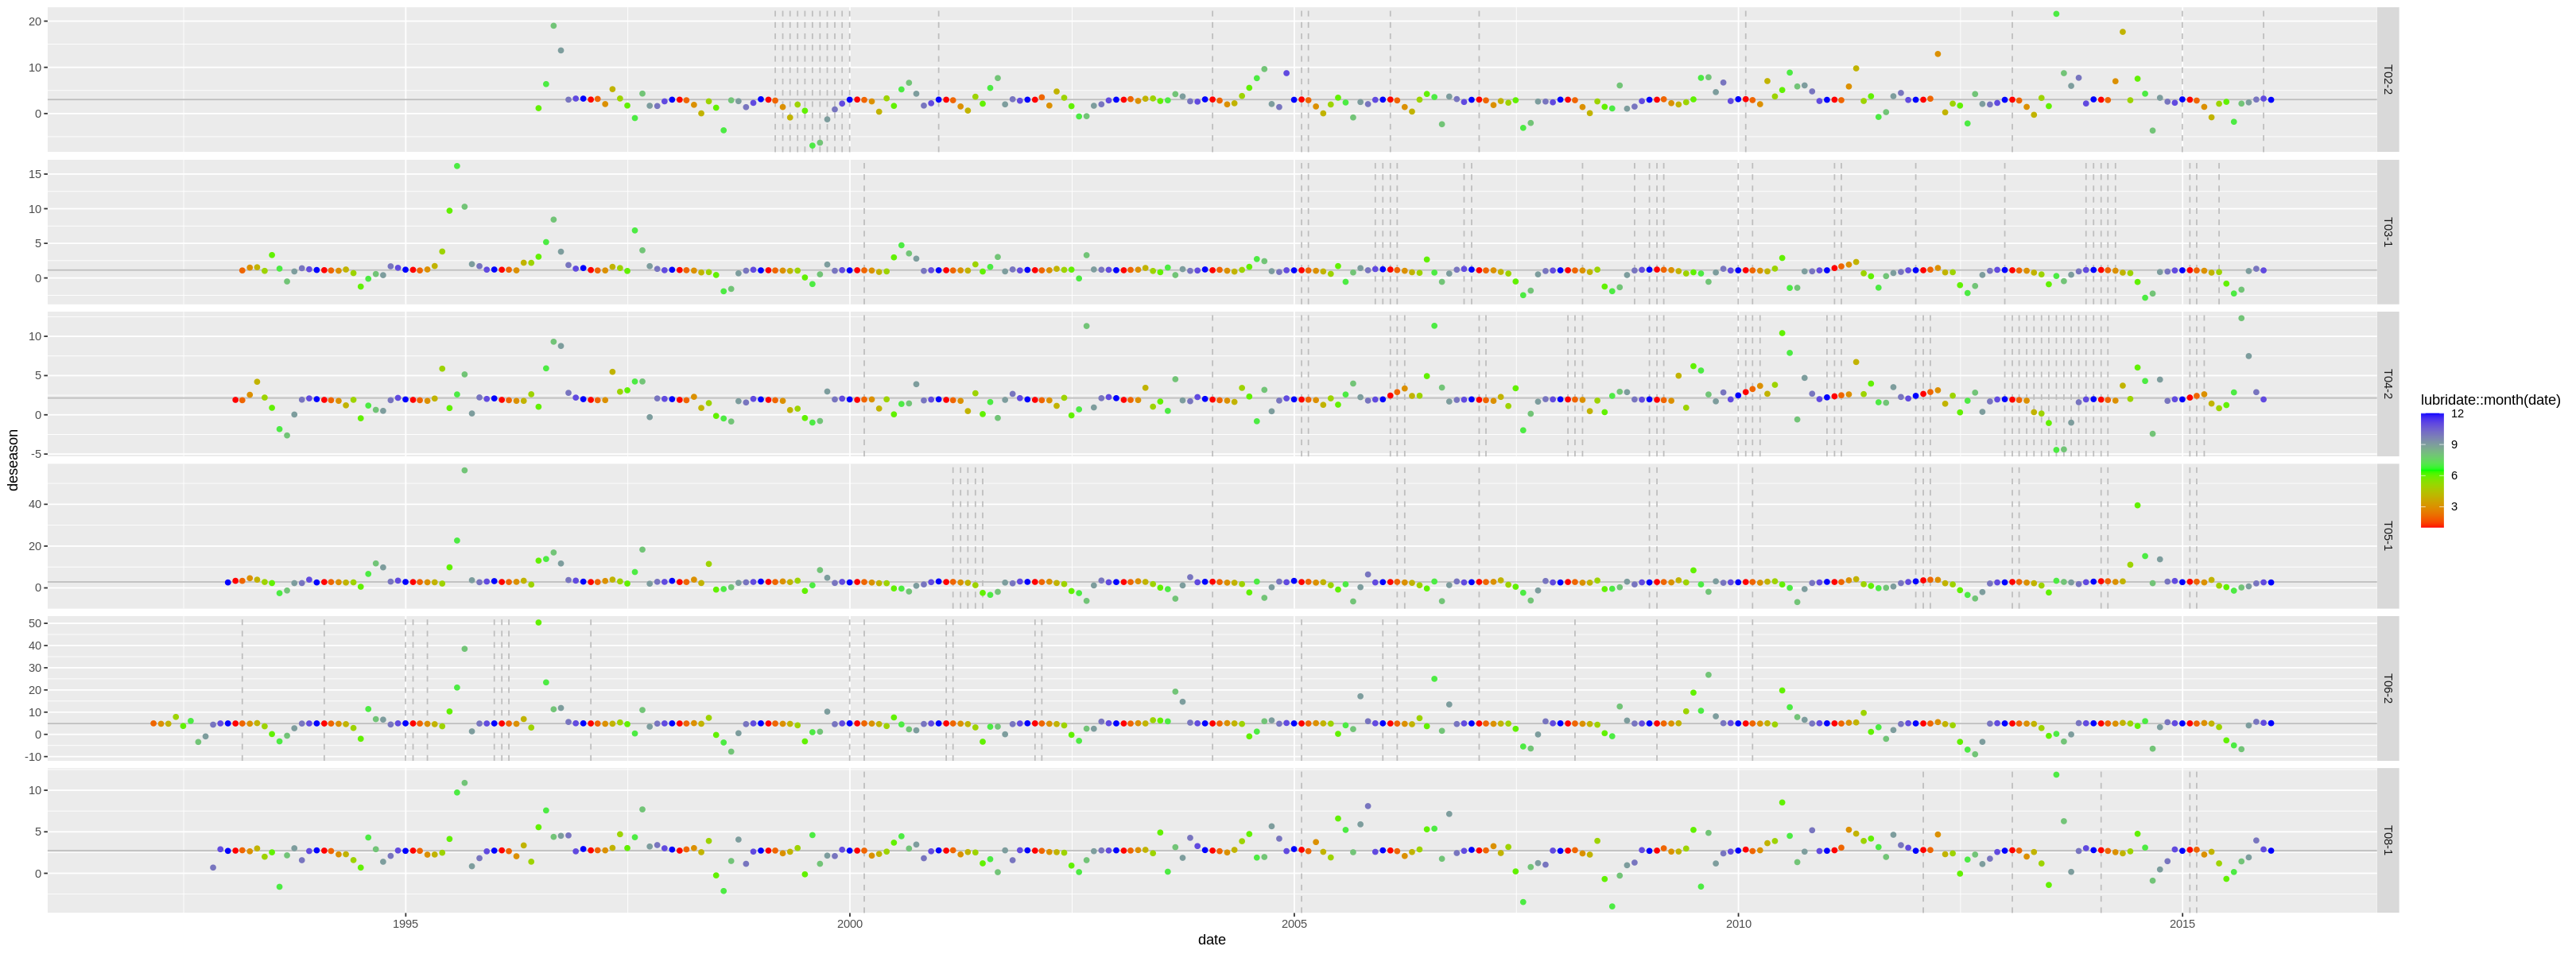

In [6]:
tmp <- tbl_deseason %>%
group_by(station) %>%
mutate(mean = mean(deseason)) %>%
ungroup() %>%
ggplot(aes(x=date, y=deseason, colour=lubridate::month(date))) +
geom_vline(data=tbl_interp %>% filter(missing), aes(xintercept=date), linetype=2, colour='grey') +
geom_hline(aes(yintercept=mean), colour='grey') +
geom_point() +
scale_color_gradientn(colours = rainbow(3)) +
facet_grid(
    rows=vars(station),
    scales="free_y"
)
print(tmp)

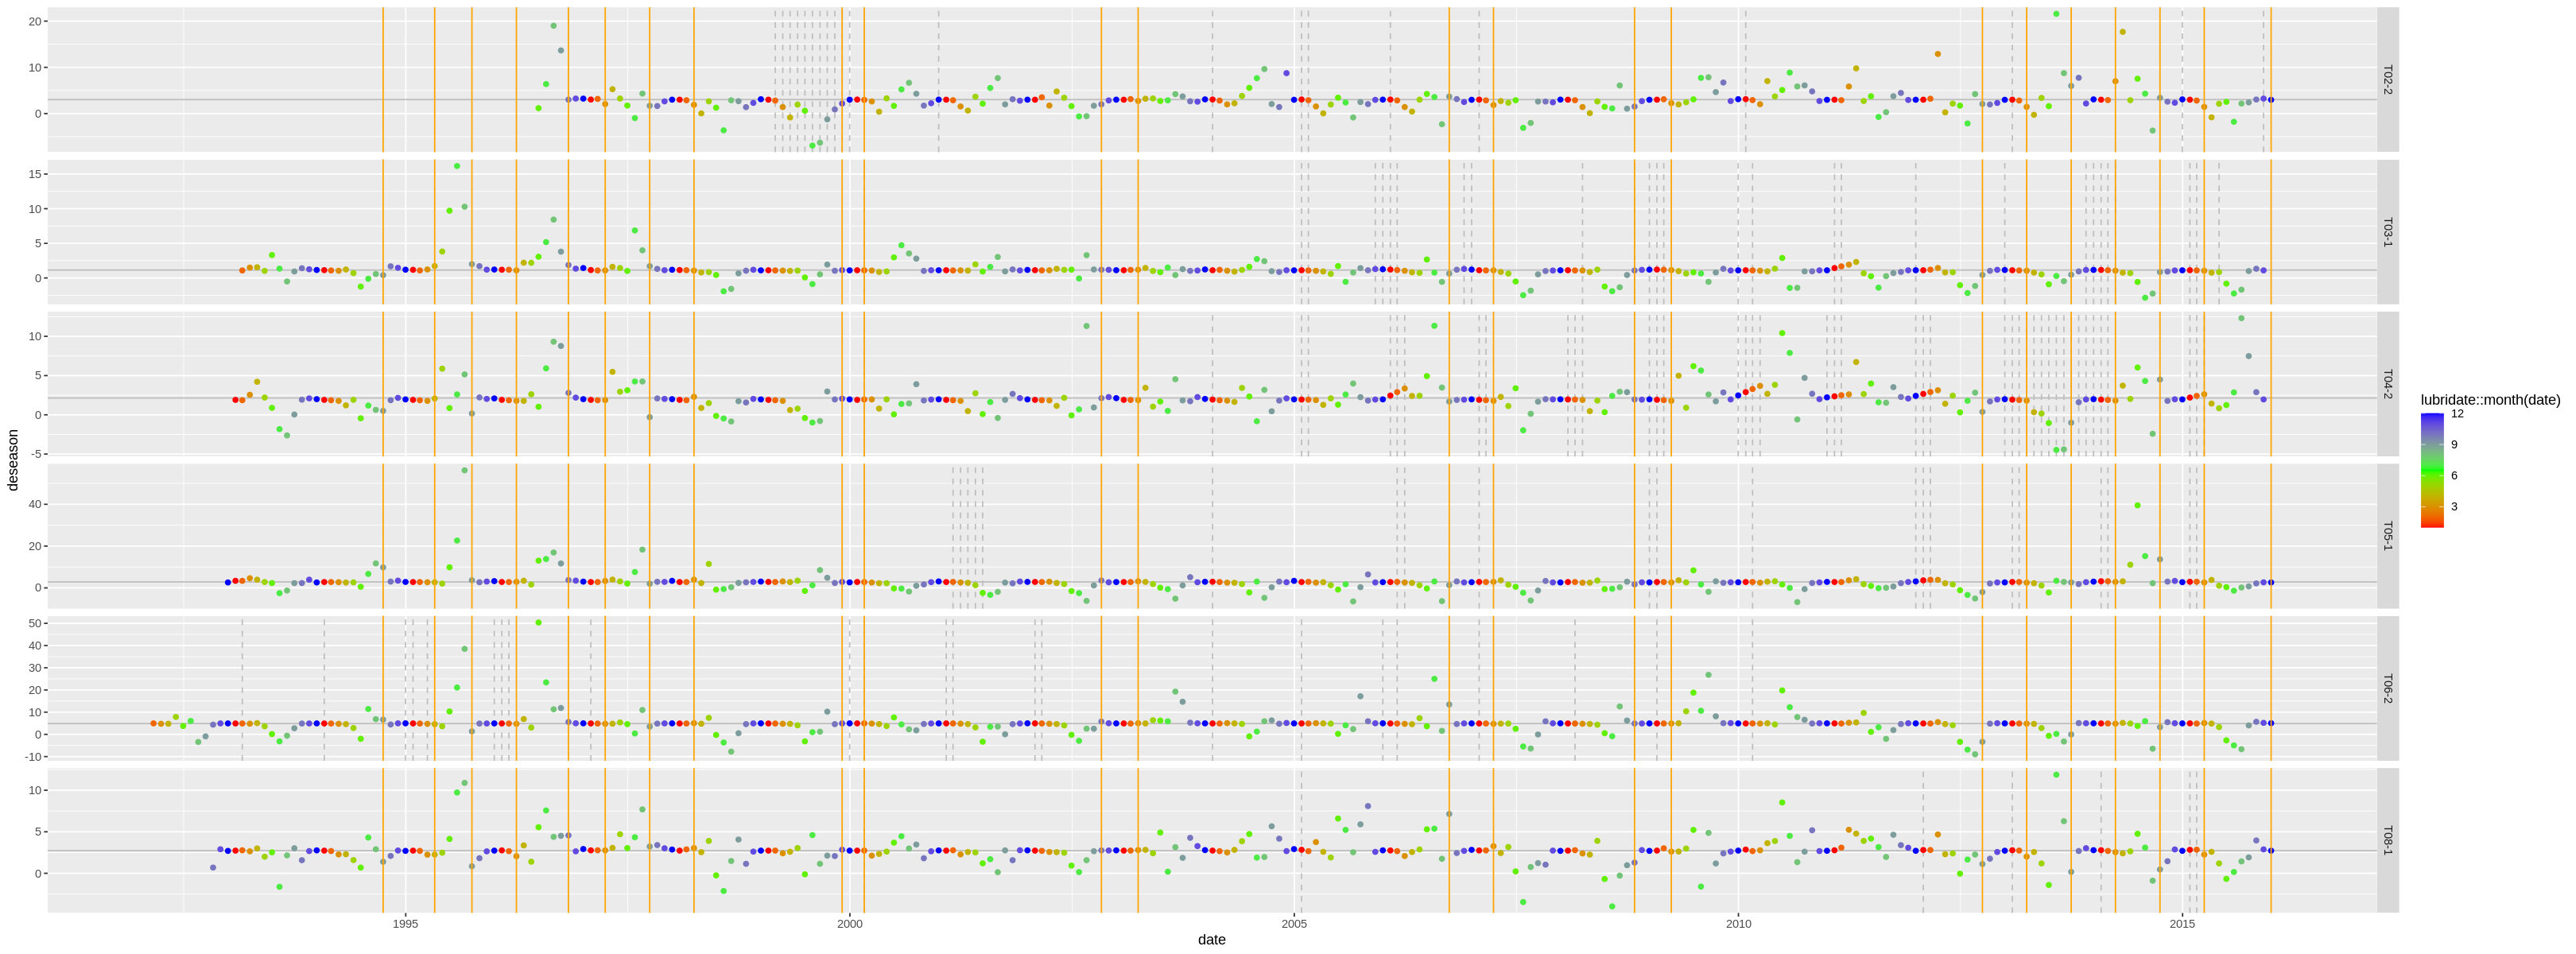

In [7]:
options(repr.plot.width = 27, repr.plot.height = 10)

cpt_data <- tbl_deseason #%>% mutate(deseason = deseason+rnorm(nrow(tbl_deseason), sd=1))
setwd('/data/notebooks/jupyterlab-workshop/cptMF/')
source_python("cpt/call.py")

keys <- unique(cpt_data$station)
cost <- as.list(rep("normal_meanvar", length(keys)))
pen <- as.list(rep("bic", length(keys)))

tmp_out <- CPT_MF(
    data = cpt_data,
    costname = cost,
    penname = pen,
    use_c = TRUE,
    return_class = TRUE,
    return_params = FALSE,
    key_value = "deseason",
    key_index = "date",
    key = "station"
)

mf_cpts <- data.frame(loc=do.call(c, tmp_out$mf_cpts))

tmp + geom_vline(data=mf_cpts, aes(xintercept=loc), colour="orange")

In [9]:
tbl_deseason

station,SITECODE,value_type,date,value,missing,month,season_mean,deseason
<chr>,<fct>,<chr>,<date>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
T02-2,T02,monthly_abun_rate,1996-06-30,0.56666667,FALSE,6,-0.5987140,1.16538062
T02-2,T02,monthly_abun_rate,1996-07-31,13.32258065,FALSE,7,6.9451237,6.37745693
T02-2,T02,monthly_abun_rate,1996-08-31,25.32258065,FALSE,8,6.3258206,18.99676003
T02-2,T02,monthly_abun_rate,1996-09-30,14.93333333,FALSE,9,1.2767686,13.65656475
T02-2,T02,monthly_abun_rate,1996-10-31,2.12903226,FALSE,10,-0.8755876,3.00461988
T02-2,T02,monthly_abun_rate,1996-11-30,1.10000000,FALSE,11,-2.1411179,3.24111791
T02-2,T02,monthly_abun_rate,1996-12-31,0.25806452,FALSE,12,-2.9712422,3.22930673
T02-2,T02,monthly_abun_rate,1997-01-31,0.03225806,FALSE,1,-2.9958315,3.02808951
T02-2,T02,monthly_abun_rate,1997-02-28,0.35714286,FALSE,2,-2.8046196,3.16176244


In [8]:
seq(as.Date("1993-01-31"), as.Date("1994-01-01"), by="month")
#print("head(tbl_monthrate)")
#print(head(tbl_monthrate))


tbl_infilled_monthly <- interpolate_monthly(tbl_monthrate)

[1] "1993-01-31" "1993-03-03" "1993-03-31" "1993-05-01" "1993-05-31"
 [6] "1993-07-01" "1993-07-31" "1993-08-31" "1993-10-01" "1993-10-31"
[11] "1993-12-01" "1993-12-31"

ERROR: Error in eval(lhs, parent, parent): object 'tbl_monthrate' not found


In [ ]:
library(dplyr)
library(ggplot2)
one <- tbl_infilled_monthly %>%
    ggplot(aes(x=DATE, y=value, colour=lubridate::month(DATE))) +
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(
        station~.,
        scales='free_y'
    ) +
    geom_vline(data = tbl_infilled_monthly %>% filter(is_infill), aes(xintercept=DATE))
print(one)

In [ ]:
tbl_2 <- tbl_infilled_monthly %>%
group_by(station) %>%
dplyr::mutate(
    ma2x12 = stats::filter(
        value, 
        filter=c(1/24, rep(1/12, 11), 1/24), 
        method='convolution', 
        sides=2),
    detrend_ma2x12 = value - ma2x12,
    month = lubridate::month(DATE)
) %>%
ungroup()

decomp_seascomp <- tbl_2 %>%
dplyr::filter(!is.na(ma2x12)) %>%
dplyr::group_by(station, month) %>% 
dplyr::summarize(
    season_mean = mean(detrend_ma2x12),
    season_sd = sd(detrend_ma2x12)
) %>% 
dplyr::mutate(
    season_mean_std = season_mean - mean(season_mean)
) %>%
dplyr::ungroup() %>%
dplyr::select(station, season_mean_std, month, season_sd)

tbl_data <- tbl_2 %>%
    right_join(decomp_seascomp, by=c("station", "month")) %>%
    mutate(deseason = (value - season_mean_std)/season_sd) #%>%
tbl_data %>%
ggplot(aes(x=DATE, y=deseason, colour=month)) +
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(
        row=vars(station), 
        col=vars(month),
        scales='free_y'
    ) +
    geom_vline(data = tbl_data %>% filter(is_infill), aes(xintercept=DATE))

#one + geom_line(data=tbl_2, aes(x=DATE, y=ma2x12)) 

    

In [ ]:
# VARIANCE DOESN'T SEEM CORRECT
tbl_data %>% 
mutate(yearmonth=tsibble::yearmonth(DATE)) %>%
tsibble::as_tsibble(index=yearmonth, key=station) %>% 
    feasts::gg_subseries(y=deseason) + 
    theme(text = element_text(size = 16))

In [ ]:
keys <- unique(tbl_data$station)
cost <- as.list(rep("normal_meanvar", length(keys)))
pen <- as.list(rep("bic", length(keys)))

tmp <- CPT_MF(
    data = tbl_data,
    costname = cost,
    penname = pen,
    use_c = TRUE,
    return_class = TRUE,
    return_params = FALSE,
    key_value = "deseason",
    key_index = "DATE",
    key = "station"
)

mf_cpts <- data.frame(loc=do.call(c, tmp$mf_cpts))
print( nrow(mf_cpts) )

tbl_data %>%
    ggplot(aes(x=DATE, y=deseason, colour=lubridate::month(DATE))) +
    geom_point() +
    scale_color_gradientn(colours = rainbow(3)) +
    facet_grid(
        station~.,
        scales='free_y'
    ) +
    #geom_vline(data = tbl_infilled_monthly %>% filter(is_infill), aes(xintercept=DATE)) +
    geom_vline(data = mf_cpts, aes(xintercept=loc))